# Lyrics analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from ast import literal_eval
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import FreqDist
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

In [2]:
# Load data with keeping structures inside data frame
songs = pd.read_csv('lyrics_processed_data.csv', converters = {'Tokenized Lyrics': literal_eval, 'Lemmatized Words': literal_eval, 'Parts of Speech': literal_eval, 'Adjectives': literal_eval, 'Nouns': literal_eval, 'Adverbs': literal_eval, 'Pronouns': literal_eval, 'Verbs': literal_eval,}) 
display(songs)

,Position,Artist,Song Title,Year,JSON file,Split Names,Song Language,Lyrics,Corpus,Tokenized Lyrics,Lemmatized Words,Parts of Speech,Adjectives,Nouns,Adverbs,Pronouns,Verbs
0,1,Gordon Jenkins and The Weavers,Goodnight Irene,1950,0.json,Gordon Jenkins,en,irene goodnight irene goodnight goodnight iren...,irene goodnight irene goodnight goodnight iren...,"[irene, goodnight, irene, goodnight, goodnight...","[irene, goodnight, irene, goodnight, goodnight...","[(irene, NN), (goodnight, VBD), (irene, JJ), (...","[irene, goodnight, irene, i'll, last, saturday...","[irene, goodnight, irene, see, dream, night, w...","[sometimes, sometimes, sometimes, fireside]",[],"[get, settle, take, take, stop, stay]"
1,2,Nat King Cole,Mona Lisa,1950,1.json,Nat King Cole,en,"mona lisa, mona lisa, men have named you you'r...",mona lisa mona lisa men named like lady mystic...,"[mona, lisa, mona, lisa, men, named, like, lad...","[mona, lisa, mona, lisa, men, name, like, lady...","[(mona, NN), (lisa, NN), (mona, NN), (lisa, VB...","[lady, mystic, blame, mona, lisa, hide, break,...","[mona, lisa, mona, name, smile, cause, lisa, s...","[lonely, lonely, art, lonely, art]",[],[]
2,4,Gary and Bing Crosby,Sam's Song,1950,3.json,Gary,en,"ah, here's a happy tune, you'll love to croon ...",ah here's happy tune love croon call sam's son...,"[ah, here's, happy, tune, love, croon, call, s...","[ah, here's, happy, tune, love, croon, call, s...","[(ah, NN), (here's, NN), (happy, JJ), (tune, N...","[happy, hum, grim, street, whistle, agree, gra...","[ah, here's, tune, croon, call, sam's, song, c...","[soon, never, learn, really, sly, still, agree...",[],"[love, find, pay, keep, tell, find]"
3,5,Gary and Bing Crosby,Simple Melody,1950,4.json,Gary,en,won't you play some simple melody like my moth...,play simple melody like mother sang one good o...,"[play, simple, melody, like, mother, sang, one...","[play, simple, melody, like, mother, sing, one...","[(play, NN), (simple, JJ), (melody, NN), (like...","[simple, good, old, simple, musical, classical...","[play, melody, mother, fashion, harmony, play,...","[simply, simply, simply]",[],[play]
4,6,Teresa Brewer,"Music, Music, Music",1950,5.json,Teresa Brewer,en,put another nickel in in the nickelodeon all i...,put another nickel nickelodeon want music musi...,"[put, another, nickel, nickelodeon, want, musi...","[put, another, nickel, nickelodeon, want, musi...","[(put, VB), (another, DT), (nickel, NN), (nick...","[want, kiss, dear, danciong, want, kiss, dear,...","[nickel, nickelodeon, music, music, music, i'd...","[close, close]",[],"[put, keep]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6404,95,Cole Swindell,Single Saturday Night,2021,6774.json,Cole Swindell,en,i was out taking shots throwing down at the sp...,taking shots throwing spot three sheets guys e...,"[taking, shots, throwing, spot, three, sheets,...","[take, shots, throw, spot, three, sheet, guy, ...","[(take, VB), (shots, NNS), (throw, VB), (spot,...","[single, light, single, right, sittin, ’, red,...","[spot, sheet, guy, saturday, night, time, crus...","[right, nowhere, nowhere, pretty, long, even, ...",[us],"[take, throw, kill, try, catch, know, find, sh..."
6405,96,Lainey Wilson,Things A Man Oughta Know,2021,6775.json,Lainey Wilson,en,i can hook a trailer on a two-inch hitch i can...,hook trailer twoinch hitch shoot shotgun catch...,"[hook, trailer, twoinch, hitch, shoot, shotgun...","[hook, trailer, twoinch, hitch, shoot, shotgun...","[(hook, NN), (trailer, NN), (twoinch, NN), (hi...","[fish, stay, tough, good, late, give, wrong, k...","[hook, trailer, twoinch, hitch, shoot, shotgun...","[fore, boy, really, yeah, fore, boy, really, y...",[],"[know, love, love, let, go, take, get, know, l..."
6406,97,BRS Kash,Throat Baby (Go Baby),2021,6776.json,BRS Kash,en,"(what's happenin', chi chi?) sexy lil' bitch...",what's happenin' chi chi sexy lil' bitch sexy ...,"[what's, happenin, ', chi, chi, sexy, lil, ', ...","[what's, happenin, ', c

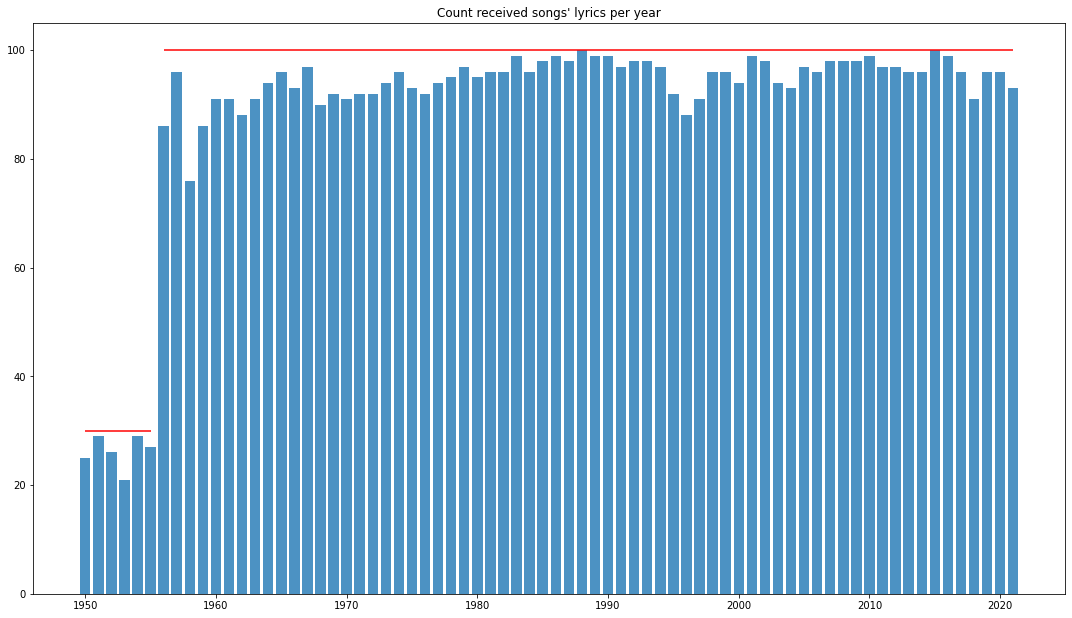

In [3]:
# Count received songs' lyrics per year
grouped_year = songs.groupby('Year').size()
plt.figure(figsize = (18.5, 10.5))
plt.bar(grouped_year.index, grouped_year, alpha = 0.8)
plt.title('Count received songs\' lyrics per year')
plt.hlines(y = 30, xmin = 1950, xmax = 1955, colors = 'r')
plt.hlines(y = 100, xmin = 1956, xmax = 2021, colors='r')

Text(0.5, 1.0, "Average number of words and unique words in songs' lyrics per year")

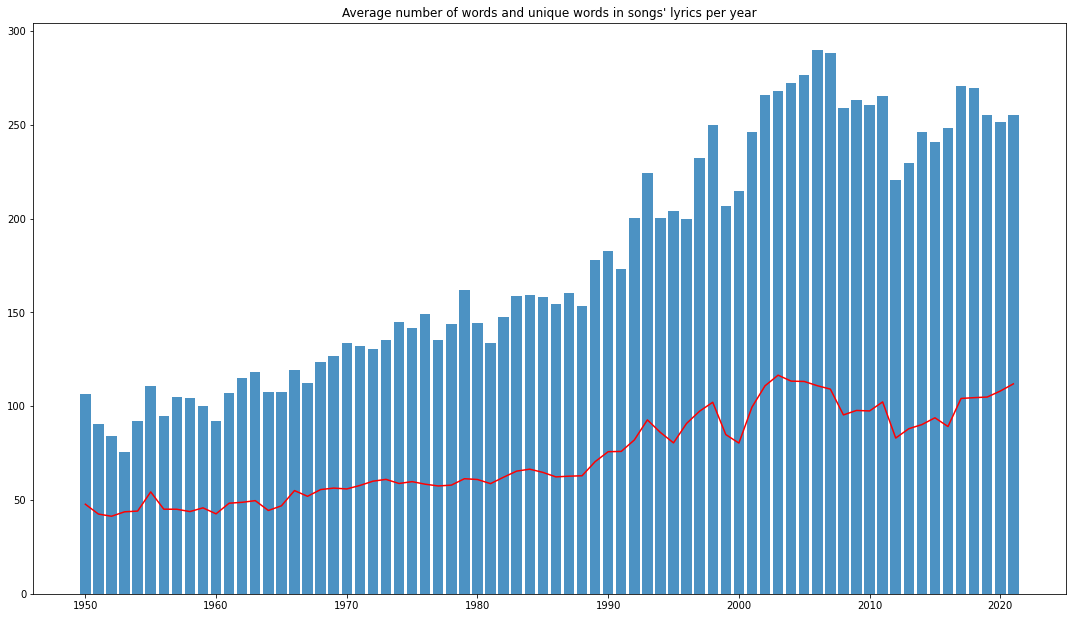

In [4]:
# Average number of words and unique in lyrics
unique = [len(set(i)) for i in songs['Corpus'].str.split(' ')]
songs['Tokenized Lyrics length'] = songs['Tokenized Lyrics'].str.len()
songs['Tokenized Unique Lyrics length'] = unique
grouped_mean = songs.groupby('Year')['Tokenized Lyrics length'].mean()
grouped_unique_mean = songs.groupby('Year')['Tokenized Unique Lyrics length'].mean()

plt.figure(figsize = (18.5, 10.5))
plt.bar(grouped_mean.index, grouped_mean, alpha = 0.8)
plt.plot(grouped_unique_mean, color = 'r')
plt.title('Average number of words and unique words in songs\' lyrics per year')

### Word cloud

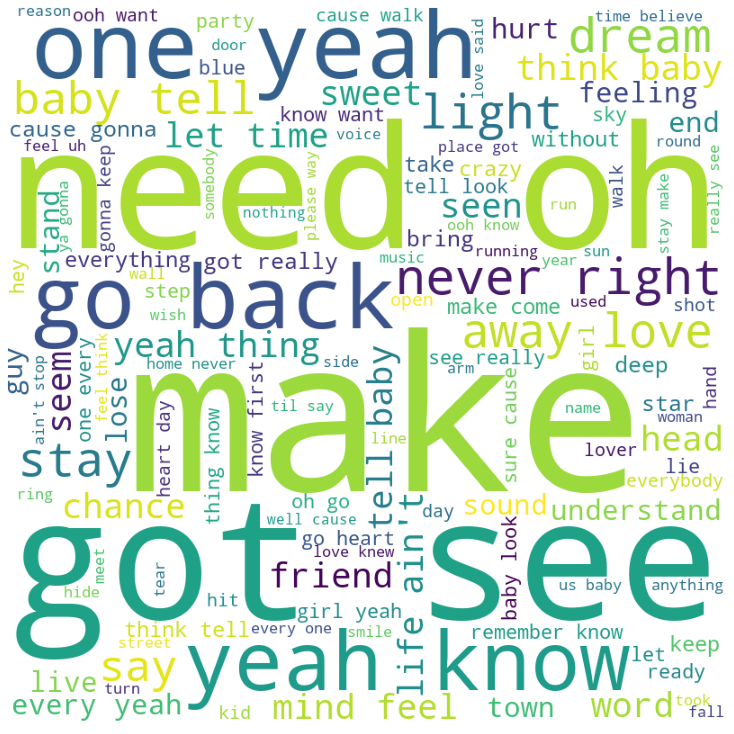

In [5]:
set_lyrics = [set(i) for i in songs['Tokenized Lyrics']]
set_lyrics = list(chain(*set_lyrics))
join_lyrics = (" ").join(set_lyrics)

STOPWORDS.add('n\'t')

wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = STOPWORDS, min_font_size = 15).generate(join_lyrics)
plt.figure(figsize = (18.5, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Most popular words

In [6]:
# Three most popular words each year
analyzed_data_range = pd.DataFrame({'Year':list(range(1950, 2022))})
lyrics_per_year = []

# Function for converting list of lists to list of sets
def lists_to_sets(l):
    return [{i for i in row} for row in l]

# Combination of lyrics per year
years = songs['Year'].unique().tolist()
for i in years:
    song_lyrics = songs['Corpus'].str.split()[songs['Year'] == i].to_list()
    set_song_lyrics = lists_to_sets(song_lyrics)
    flat_song_lyrics = [item for i in set_song_lyrics for item in i]
    lyrics_per_year.append(flat_song_lyrics)
    
# Set for every song in particular year
analyzed_data_range['Combined Lyrics'] = lyrics_per_year


# Function for getting first values from tuple of most popular words
def first_from_list_of_tuples(lst):
    return [i[0] for i in lst]

lst_of_top3_words = [] 

# Create list of top 3 popular words
for i in analyzed_data_range['Combined Lyrics']:
    frq = FreqDist(i)
    top3_words = first_from_list_of_tuples(frq.most_common(3))
    lst_of_top3_words.append(top3_words)

# Set for every song in particular year
analyzed_data_range['Most Popular Words'] = lst_of_top3_words

display(analyzed_data_range)

,Year,Combined Lyrics,Most Popular Words
0,1950,"[country, jump, i'm, great, gonna, stay, got, ...","[love, see, like]"
1,1951,"[us, yet, tell, say, try, can't, love's, reall...","[love, heart, know]"
2,1952,"[magic, fortune, turning, i'm, precious, arrow...","[love, i'll, kiss]"
3,1953,"[lips, tell, worry, eyes, must, i'm, like, spe...","[love, i'm, heart]"
4,1954,"[little, sables, look, chair, call, say, i'm, ...","[love, heart, know]"
...,...,...,...
67,2017,"[singing, i'm, although, much, dance, follow, ...","[i'm, like, know]"
68,2018,"[peaceful, god, i'm, miss, tatted, without, wi...","[i'm, like, yeah]"
69,2019,"[road, tell, baby, that's, ha, attached, i'm, ...","[i'm, yeah, know]"
70,2020,"[feel, enough, baby, road, look, blinded, call...","[like, i'm, know]"


In [7]:
# 3 the most popular words of 1950 - 2021
most_popular_words_list = analyzed_data_range['Most Popular Words'].tolist()
most_popular_words = first_from_list_of_tuples(Counter(chain.from_iterable(most_popular_words_list)).most_common(3))
most_popular_words

['know', "i'm", 'love']

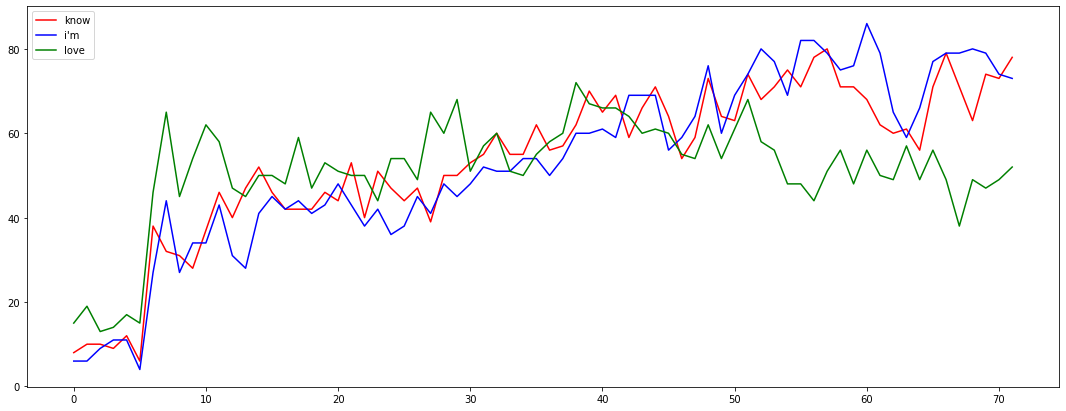

In [8]:
# Popular words occurence plot
def count_most_popular_word(list_of_words, word):
    return list_of_words.count(word)

first_most_popular_word_occurence = [count_most_popular_word(i, most_popular_words[0]) for i in analyzed_data_range['Combined Lyrics']]
second_most_popular_word_occurence = [count_most_popular_word(i, most_popular_words[1]) for i in analyzed_data_range['Combined Lyrics']]
third_most_popular_word_occurence = [count_most_popular_word(i, most_popular_words[2]) for i in analyzed_data_range['Combined Lyrics']]

plt.figure(figsize = (18.5, 7))
plt.plot(first_most_popular_word_occurence, color = 'red', label = most_popular_words[0])
plt.plot(second_most_popular_word_occurence, color = 'blue', label = most_popular_words[1])
plt.plot(third_most_popular_word_occurence, color = 'green', label = most_popular_words[2])
plt.legend(most_popular_words)

### Bad words classifier

In [9]:
# List of bad words
bad_words_df = pd.read_csv('https://www.cs.cmu.edu/~biglou/resources/bad-words.txt', sep="\n", header=None, names = ["Word"])
bad_words = bad_words_df["Word"].tolist()

In [10]:
# Measure level of vulgarity for each song in years 1950 - 2021 (in %)
# Calculate % of bad words
def level_of_vulgarity(lemm_list):
    counter = 0
    for i in lemm_list:
        if i in bad_words:
            counter += 1
    level = counter / len(lemm_list) * 100
    return level

list_of_levels = []
for i in songs['Lemmatized Words']:
    list_of_levels.append(level_of_vulgarity(i))
    
songs['Vulgarity Level'] = list_of_levels
songs['Vulgarity Level'] = songs['Vulgarity Level'].round(2)

level_of_vulgarity_df = songs[['Position', 'Artist', 'Song Title', 'Year', 'Vulgarity Level']]

display(level_of_vulgarity_df)

,Position,Artist,Song Title,Year,Vulgarity Level
0,1,Gordon Jenkins and The Weavers,Goodnight Irene,1950,0.00
1,2,Nat King Cole,Mona Lisa,1950,2.82
2,4,Gary and Bing Crosby,Sam's Song,1950,0.00
3,5,Gary and Bing Crosby,Simple Melody,1950,3.12
4,6,Teresa Brewer,"Music, Music, Music",1950,0.00
...,...,...,...,...,...
6404,95,Cole Swindell,Single Saturday Night,2021,2.25
6405,96,Lainey Wilson,Things A Man Oughta Know,2021,3.08
6406,97,BRS Kash,Throat Baby (Go Baby),2021,11.53
6407,98,Rod Wave,Tombstone,2021,6.25


Text(0.5, 1.0, 'Vulgarity level of lyrics')

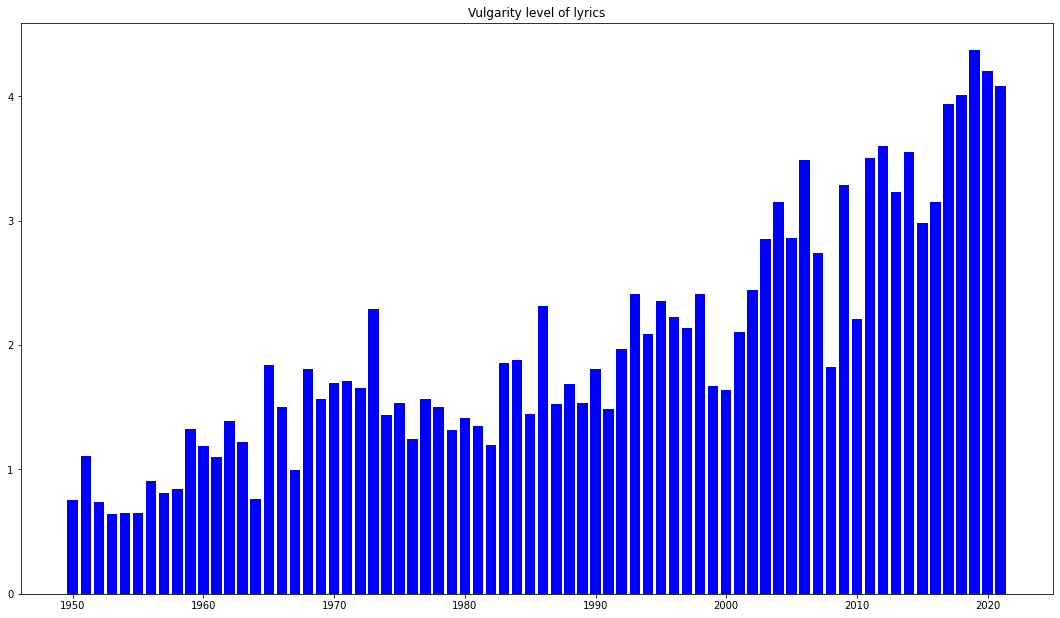

In [11]:
# Vulgarity level each year plot
grouped_vulgsrity = songs.groupby('Year')['Vulgarity Level'].aggregate('mean').tolist()
analyzed_data_range['Mean Vulgarity'] = grouped_vulgsrity
plt.figure(figsize = (18.5, 10.5))
plt.bar(analyzed_data_range['Year'], grouped_vulgsrity, color = 'blue')
plt.title('Vulgarity level of lyrics')

In [12]:
# 3 most popular words classified as bad words each year
lst_of_top3_bad_words = []

for i in analyzed_data_range['Combined Lyrics']:
    i = pd.Series(i)
    bad_words_series = pd.Series(bad_words)
    bad_lyrics = i[i.isin(bad_words_series)]
    frq = FreqDist(bad_lyrics)
    top3_bad_words = first_from_list_of_tuples(frq.most_common(3))
    lst_of_top3_bad_words.append(top3_bad_words)
    
analyzed_data_range['Most Popular Bad Words'] = lst_of_top3_bad_words

display(analyzed_data_range)

,Year,Combined Lyrics,Most Popular Words,Mean vulgarity,Most Popular Bad Words
0,1950,"[country, jump, i'm, great, gonna, stay, got, ...","[love, see, like]",0.757600,"[fire, die, demon]"
1,1951,"[us, yet, tell, say, try, can't, love's, reall...","[love, heart, know]",1.108621,"[die, desire, lies]"
2,1952,"[magic, fortune, turning, i'm, precious, arrow...","[love, i'll, kiss]",0.737308,"[fire, slave, desire]"
3,1953,"[lips, tell, worry, eyes, must, i'm, like, spe...","[love, i'm, heart]",0.643810,"[dies, death, jesus]"
4,1954,"[little, sables, look, chair, call, say, i'm, ...","[love, heart, know]",0.652759,"[fear, die, gay]"
...,...,...,...,...,...
67,2017,"[singing, i'm, although, much, dance, follow, ...","[i'm, like, know]",3.941042,"[bitch, shit, fuck]"
68,2018,"[peaceful, god, i'm, miss, tatted, without, wi...","[i'm, like, yeah]",4.008022,"[shit, bitch, fuck]"
69,2019,"[road, tell, baby, that's, ha, attached, i'm, ...","[i'm, yeah, know]",4.372292,"[shit, fuck, bitch]"
70,2020,"[feel, enough, baby, road, look, blinded, call...","[like, i'm, know]",4.203958,"[bitch, fuck, shit]"


In [13]:
# 3 the most popular bad words of 1950 - 2021
most_popular_bad_words_list = analyzed_data_range['Most Popular Bad Words'].tolist()
most_popular_bad_words = first_from_list_of_tuples(Counter(chain.from_iterable(most_popular_bad_words_list)).most_common(3))
most_popular_bad_words

['die', 'shit', 'fire']

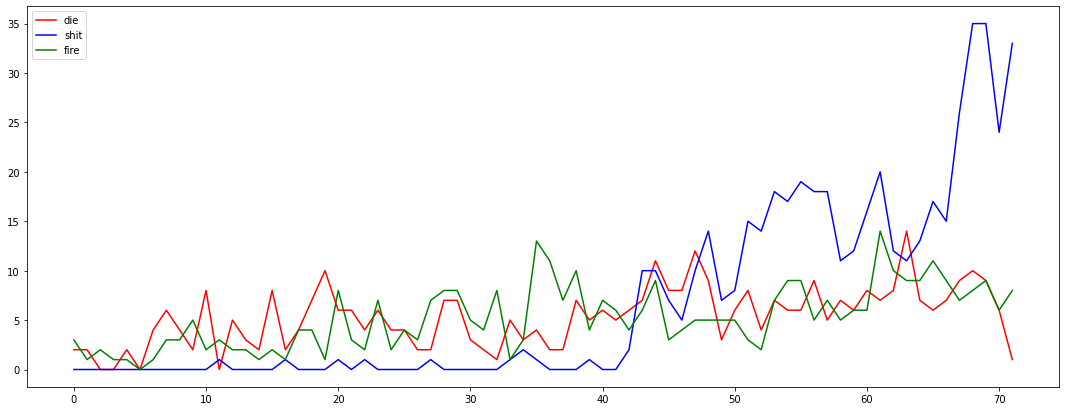

In [14]:
# Popular bad words occurence plot
first_most_popular_bad_word_occurence = [count_most_popular_word(i, most_popular_bad_words[0]) for i in analyzed_data_range['Combined Lyrics']]
second_most_popular_bad_word_occurence = [count_most_popular_word(i, most_popular_bad_words[1]) for i in analyzed_data_range['Combined Lyrics']]
third_most_popular_bad_word_occurence = [count_most_popular_word(i, most_popular_bad_words[2]) for i in analyzed_data_range['Combined Lyrics']]

plt.figure(figsize = (18.5, 7))
plt.plot(first_most_popular_bad_word_occurence, color = 'red', label = most_popular_words[0])
plt.plot(second_most_popular_bad_word_occurence, color = 'blue', label = most_popular_words[1])
plt.plot(third_most_popular_bad_word_occurence, color = 'green', label = most_popular_words[2])
plt.legend(most_popular_bad_words)

### Sentiment analysis

In [15]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
sentiment = SentimentIntensityAnalyzer()
negative = []
neutral = []
positive = []
compound = []
rate = []
for i in songs['Lyrics']:
    sent = sentiment.polarity_scores(i)
    negative.append(sent['neg'])
    neutral.append(sent['neu'])
    positive.append(sent['pos'])
    compound.append(sent['compound'])
    if sent['compound'] > 0:
        rate.append('Positive')
    elif sent['compound'] < 0:
        rate.append('Negative')
    else:
        rate.append('Neutral')
songs['Negative'] = negative
songs['Neutral'] = neutral
songs['Positive'] = positive
songs['Compound'] = compound
songs['Rate'] = rate

display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Negative', 'Neutral', 'Positive', 'Compound', 'Rate']])

,Position,Artist,Song Title,Year,Negative,Neutral,Positive,Compound,Rate
0,1,Gordon Jenkins and The Weavers,Goodnight Irene,1950,0.065,0.822,0.113,0.8176,Positive
1,2,Nat King Cole,Mona Lisa,1950,0.144,0.615,0.241,0.9638,Positive
2,4,Gary and Bing Crosby,Sam's Song,1950,0.044,0.816,0.139,0.9836,Positive
3,5,Gary and Bing Crosby,Simple Melody,1950,0.087,0.697,0.216,0.9868,Positive
4,6,Teresa Brewer,"Music, Music, Music",1950,0.000,0.833,0.167,0.9849,Positive
...,...,...,...,...,...,...,...,...,...
6404,95,Cole Swindell,Single Saturday Night,2021,0.030,0.867,0.103,0.9880,Positive
6405,96,Lainey Wilson,Things A Man Oughta Know,2021,0.057,0.776,0.167,0.9897,Positive
6406,97,BRS Kash,Throat Baby (Go Baby),2021,0.089,0.725,0.186,0.9967,Positive
6407,98,Rod Wave,Tombstone,2021,0.135,0.599,0.266,0.9966,Positive


In [16]:
# Mean sentiment per year
neg = songs.groupby('Year')['Negative'].aggregate('mean').tolist()
neu = songs.groupby('Year')['Neutral'].aggregate('mean').tolist()
pos = songs.groupby('Year')['Positive'].aggregate('mean').tolist()
comp = songs.groupby('Year')['Compound'].aggregate('mean').tolist()
analyzed_data_range['Negative'] = neg
analyzed_data_range['Neutral'] = neu
analyzed_data_range['Positive'] = pos
analyzed_data_range['Compound'] = comp
display(analyzed_data_range)

,Year,Combined Lyrics,Most Popular Words,Mean vulgarity,Most Popular Bad Words,Negative,Neutral,Positive,Compound
0,1950,"[country, jump, i'm, great, gonna, stay, got, ...","[love, see, like]",0.757600,"[fire, die, demon]",0.056880,0.703440,0.239520,0.970280
1,1951,"[us, yet, tell, say, try, can't, love's, reall...","[love, heart, know]",1.108621,"[die, desire, lies]",0.052345,0.734724,0.213000,0.858731
2,1952,"[magic, fortune, turning, i'm, precious, arrow...","[love, i'll, kiss]",0.737308,"[fire, slave, desire]",0.058846,0.768308,0.172885,0.757658
3,1953,"[lips, tell, worry, eyes, must, i'm, like, spe...","[love, i'm, heart]",0.643810,"[dies, death, jesus]",0.075714,0.717905,0.206381,0.714714
4,1954,"[little, sables, look, chair, call, say, i'm, ...","[love, heart, know]",0.652759,"[fear, die, gay]",0.050517,0.726414,0.223034,0.840010
...,...,...,...,...,...,...,...,...,...
67,2017,"[singing, i'm, although, much, dance, follow, ...","[i'm, like, know]",3.941042,"[bitch, shit, fuck]",0.104531,0.742104,0.153417,0.379510
68,2018,"[peaceful, god, i'm, miss, tatted, without, wi...","[i'm, like, yeah]",4.008022,"[shit, bitch, fuck]",0.107780,0.730989,0.161253,0.311246
69,2019,"[road, tell, baby, that's, ha, attached, i'm, ...","[i'm, yeah, know]",4.372292,"[shit, fuck, bitch]",0.111927,0.730698,0.157396,0.299486
70,2020,"[feel, enough, baby, road, look, blinded, call...","[like, i'm, know]",4.203958,"[bitch, fuck, shit]",0.105958,0.738688,0.155354,0.295326


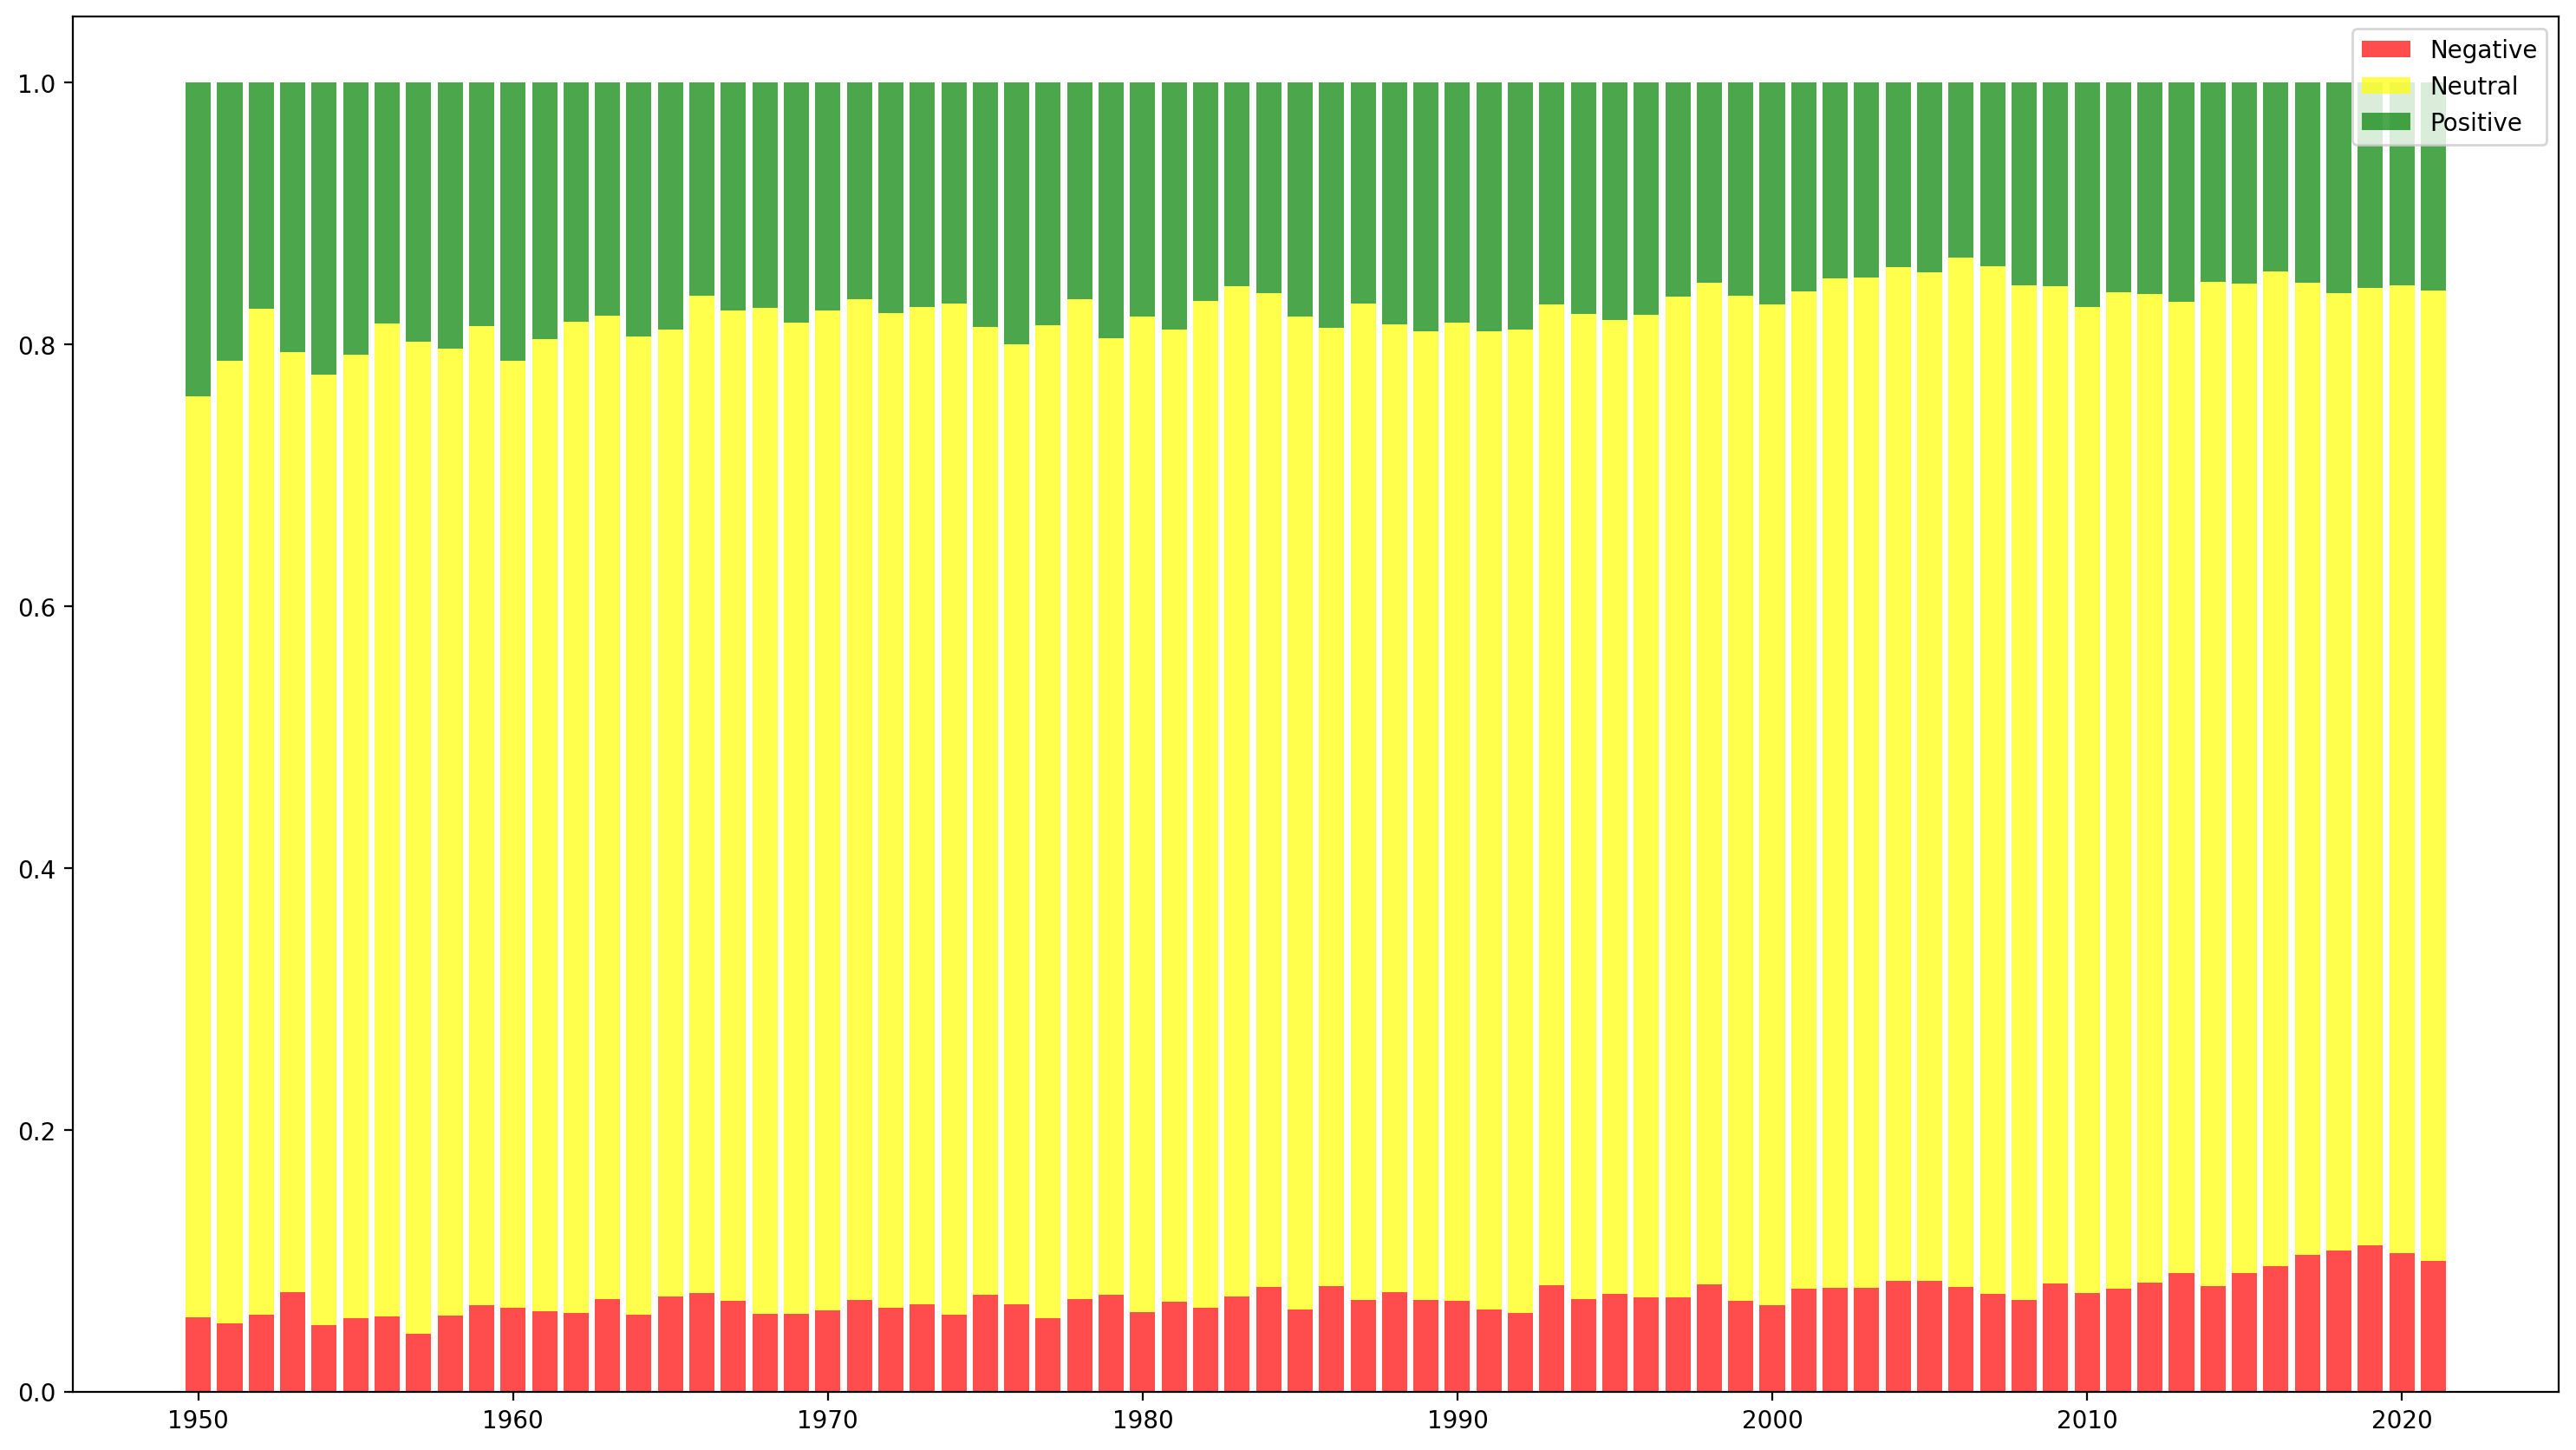

In [17]:
plt.figure(figsize=(18.5, 10.5), dpi=200)
plt.bar(analyzed_data_range['Year'], analyzed_data_range['Negative'], color = 'red', label = 'Negative', alpha = 0.7)
plt.bar(analyzed_data_range['Year'], analyzed_data_range['Neutral'], color = 'yellow', bottom = analyzed_data_range['Negative'].values, label = 'Neutral', alpha = 0.7)
plt.bar(analyzed_data_range['Year'], analyzed_data_range['Positive'], color = 'green', bottom = list(np.add(analyzed_data_range['Negative'].values, analyzed_data_range['Neutral'].values)), label = "Positive", alpha = 0.7)
plt.legend()
plt.show()

In [18]:
# The most positive songs
display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Negative', 'Neutral', 'Positive', 'Compound', 'Rate']].sort_values(['Positive', 'Neutral', 'Negative'], ascending = False).head(5))

,Position,Artist,Song Title,Year,Negative,Neutral,Positive,Compound,Rate
874,14,Beatles,Love Me Do,1964,0.015,0.367,0.617,0.9992,Positive
637,52,Paris Sisters,I Love How You Love Me,1961,0.018,0.384,0.598,0.9997,Positive
1994,15,Diana Ross,Love Hangover,1976,0.053,0.357,0.590,1.0000,Positive
834,72,Marvin Gaye,Pride And Joy,1963,0.016,0.413,0.571,0.9997,Positive
1507,93,Pacific Gas and Electric,Are You Ready?,1970,0.013,0.419,0.568,0.9999,Positive


In [19]:
# The most negative songs
display(songs[['Position', 'Artist', 'Song Title', 'Year', 'Negative', 'Neutral', 'Positive', 'Compound', 'Rate']].sort_values(['Negative', 'Neutral', 'Positive'], ascending = False).head(5))

,Position,Artist,Song Title,Year,Negative,Neutral,Positive,Compound,Rate
6008,75,Jon Bellion,All Time Low,2017,0.710,0.263,0.027,-0.9999,Negative
5502,57,Big Sean feat. Nicki Minaj,Dance (A$$),2012,0.592,0.352,0.056,-0.9999,Negative
2004,26,K.C. and The Sunshine Band,"(Shake, Shake, Shake) Shake Your Booty",1976,0.558,0.382,0.060,-0.9977,Negative
3095,59,Michael Jackson,Bad,1987,0.479,0.482,0.038,-0.9999,Negative
2816,73,Bananarama,Cruel Summer,1984,0.473,0.491,0.036,-0.9996,Negative


In [20]:
# analysis for most popular artist